# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [254]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import copy
import random
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_rows', None)

### 데이터 셋 읽어오기

In [164]:
train = pd.read_csv("train.csv") # 학습용 데이터
test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [165]:
train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


## 2. 데이터 시각화

### 데이터 확인

In [166]:
print(train.duplicated().sum())

3519


In [167]:
train=train.drop_duplicates()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55780 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              55780 non-null  float64
 1   customer_country         54806 non-null  object 
 2   business_unit            55780 non-null  object 
 3   com_reg_ver_win_rate     14114 non-null  float64
 4   customer_idx             55780 non-null  int64  
 5   customer_type            14422 non-null  object 
 6   enterprise               55780 non-null  object 
 7   historical_existing_cnt  12370 non-null  float64
 8   id_strategic_ver         3339 non-null   float64
 9   it_strategic_ver         1108 non-null   float64
 10  idit_strategic_ver       4447 non-null   float64
 11  customer_job             38976 non-null  object 
 12  lead_desc_length         55780 non-null  int64  
 13  inquiry_type             54889 non-null  object 
 14  product_category      

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5271 non-null   int64  
 1   bant_submit              5271 non-null   float64
 2   customer_country         5271 non-null   object 
 3   business_unit            5271 non-null   object 
 4   com_reg_ver_win_rate     1788 non-null   float64
 5   customer_idx             5271 non-null   int64  
 6   customer_type            3814 non-null   object 
 7   enterprise               5271 non-null   object 
 8   historical_existing_cnt  1275 non-null   float64
 9   id_strategic_ver         593 non-null    float64
 10  it_strategic_ver         53 non-null     float64
 11  idit_strategic_ver       646 non-null    float64
 12  customer_job             3832 non-null   object 
 13  lead_desc_length         5271 non-null   int64  
 14  inquiry_type            

In [26]:
print('train shape: ',train.shape)
print('test shape: ',test.shape)

train shape:  (55780, 29)
test shape:  (5271, 30)


In [27]:
test=test.drop(['id','is_converted'],axis=1)

In [28]:
train.isnull().sum()[train.isnull().sum()>0]

customer_country             974
com_reg_ver_win_rate       41666
customer_type              41358
historical_existing_cnt    43410
id_strategic_ver           52441
it_strategic_ver           54672
idit_strategic_ver         51333
customer_job               16804
inquiry_type                 891
product_category           17174
product_subcategory        46774
product_modelname          46749
customer_country.1           974
expected_timeline          28292
ver_win_rate_x             37993
ver_win_ratio_per_bu       40896
business_area              37993
business_subarea           50600
dtype: int64

In [29]:
test.isnull().sum()[test.isnull().sum()>0]

com_reg_ver_win_rate       3483
customer_type              1457
historical_existing_cnt    3996
id_strategic_ver           4678
it_strategic_ver           5218
idit_strategic_ver         4625
customer_job               1439
inquiry_type               1292
product_category           1858
product_subcategory        4478
product_modelname          4709
expected_timeline          2408
ver_win_rate_x             2898
ver_win_ratio_per_bu       3365
business_area              2898
business_subarea           3455
dtype: int64

### 결측치 처리(제거)

In [222]:
# columns
colsByType={}

colsByType['categorical']=train.columns[train.dtypes=='object'].tolist()
colsByType['numerical']=train.columns[train.dtypes!='object'].tolist()
#colsByType['numerical'].remove('is_converted')

print('\nnumerical columns: '+str(len(colsByType['numerical'])))
print('categorical columns: '+str(len(colsByType['categorical'])))
print('total columns: '+str(len(colsByType['numerical'])+len(colsByType['categorical'])))


numerical columns: 7
categorical columns: 7
total columns: 14


In [223]:
# 결측치 테이블
nanCols=train.columns.to_list()
temp=[]
for col in nanCols:
    if col in colsByType['numerical']:
        temp.append([col,'num',train[col].isnull().sum(),''])
    else:
        temp.append([col,'cat',train[col].isnull().sum(),''])

nanData=pd.DataFrame(data=temp,columns=['Column','Type','Count','Deal'])
nanData

,Column,Type,Count,Deal
0,bant_submit,num,0,
1,customer_country,cat,974,
2,business_unit,cat,0,
3,customer_idx,num,0,
4,enterprise,cat,0,
5,lead_desc_length,num,0,
6,inquiry_type,cat,891,
7,customer_country.1,cat,974,
8,customer_position,cat,0,
9,response_corporate,cat,0,


In [224]:
temp=[]
rows=train.shape[0]
for col in train.columns.to_list():
    temp.append([col,(train[col].isnull().sum()/rows).round(3)])
nanCol=pd.DataFrame(data=temp,columns=['Column','Percent'])
nanCol

,Column,Percent
0,bant_submit,0.000
1,customer_country,0.017
2,business_unit,0.000
3,customer_idx,0.000
4,enterprise,0.000
5,lead_desc_length,0.000
6,inquiry_type,0.016
7,customer_country.1,0.017
8,customer_position,0.000
9,response_corporate,0.000


In [225]:
# 삭제 후보군 결측치 10% 이상
baseLine=int(rows*0.1)

delCol=train.isnull().sum()[train.isnull().sum()>baseLine].index.tolist()
delCol

[]

In [226]:
train=train.drop(delCol,axis=1)
for dc in delCol:
    nanData.loc[nanData['Column']==dc,'Deal']='Remove'
nanData

,Column,Type,Count,Deal
0,bant_submit,num,0,
1,customer_country,cat,974,
2,business_unit,cat,0,
3,customer_idx,num,0,
4,enterprise,cat,0,
5,lead_desc_length,num,0,
6,inquiry_type,cat,891,
7,customer_country.1,cat,974,
8,customer_position,cat,0,
9,response_corporate,cat,0,


### 데이터 전처리 및 시각화

In [227]:
# data copy
data_visual=train.copy(deep=True)

# columns
colsByType={}

colsByType['categorical']=train.columns[train.dtypes=='object'].tolist()
colsByType['numerical']=train.columns[train.dtypes!='object'].tolist()
colsByType['numerical'].remove('is_converted')

print('\nnumerical columns: '+str(len(colsByType['numerical'])))
print('categorical columns: '+str(len(colsByType['categorical'])))
print('total columns: '+str(len(colsByType['numerical'])+len(colsByType['categorical'])))


numerical columns: 6
categorical columns: 7
total columns: 13


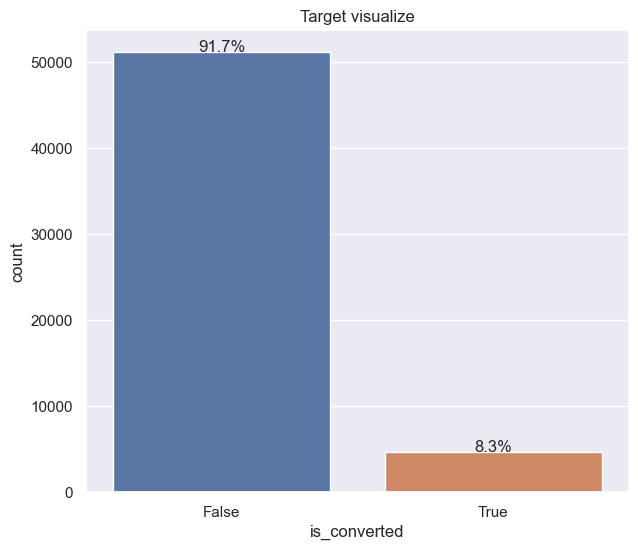

In [228]:
# target
def write_percent(ax, total_size):
    '''도형 객체를 순회하며 막대 상단에 타깃값 비율 표시'''
    for patch in ax.patches:
        height = patch.get_height()     # 도형 높이(데이터 개수)
        width = patch.get_width()       # 도형 너비
        left_coord = patch.get_x()      # 도형 왼쪽 테두리의 x축 위치
        percent = height/total_size*100 # 타깃값 비율
        
        # (x, y) 좌표에 텍스트 입력 
        ax.text(x=left_coord + width/2.0,    # x축 위치
                y=height + total_size*0.001, # y축 위치
                s=f'{percent:1.1f}%',        # 입력 텍스트
                ha='center')                 # 가운데 정렬
def hist_category_single(figsize,coordinate,data):
    sns.set(rc={'figure.figsize': figsize})

    ax=sns.countplot(x=coordinate,data=data)
    write_percent(ax,len(data))
    ax.set_title('Target visualize')

hist_category_single((7,6),data_visual['is_converted'].index,data_visual['is_converted'])

데이터 불평등
False:True = 9.1:8.3 (약) 

In [131]:
data_visual[colsByType['categorical']].nunique()

customer_country      15399
business_unit             5
enterprise                2
inquiry_type             71
customer_country.1    15399
customer_position       117
response_corporate       53
dtype: int64

너무 많은 카테고리 정리 필요


In [46]:
data_visual['customer_country.1'].value_counts()

//India                                                                                                                            2956
/São Paulo/Brazil                                                                                                                  1200
//United Kingdom                                                                                                                    800
//Philippines                                                                                                                       661
//                                                                                                                                  649
//United States                                                                                                                     634
/Mumbai/India                                                                                                                       588
//Brazil                                        

In [50]:
(data_visual['customer_country']!=data_visual['customer_country.1']).sum()

974

In [86]:
x=data_visual['customer_country'].apply(lambda x:x.lower().replace(' ','') if type(x)==type('') else np.nan)
x=x.apply(lambda x:x.split('/')[-1] if type(x)==type('') else np.nan)
x.value_counts()

india                                                                               16623
brazil                                                                               8237
unitedstates                                                                         3088
mexico                                                                               2515
philippines                                                                          2467
                                                                                     1944
colombia                                                                             1922
u.a.e                                                                                1508
unitedkingdom                                                                        1501
chile                                                                                1146
saudiarabia                                                                          1140
peru      

In [115]:
data_visual['inquiry_type'].value_counts()

Quotation or purchase consultation                                                                                     22908
Quotation or Purchase Consultation                                                                                     17228
Sales Inquiry                                                                                                           8844
Product Information                                                                                                     1100
Other                                                                                                                    901
Usage or technical consultation                                                                                          654
Technical Consultation                                                                                                   413
Trainings                                                                                                                376


In [117]:
x=data_visual['inquiry_type'].apply(lambda x:x.lower().replace('_',' ') if type(x)==type('') else np.nan)
x.value_counts()

quotation or purchase consultation                                                                                     40233
sales inquiry                                                                                                           8848
usage or technical consultation                                                                                         1118
product information                                                                                                     1100
other                                                                                                                    922
technical consultation                                                                                                   417
trainings                                                                                                                376
services                                                                                                                 361


In [229]:
# 묶음
# [quotation, purchase ] -> QP
# technical -> TC
# information -> IF
# partnership -> PS
# demo -> DM
# trainings ->TS
# services -> SV
# sales -> SA
# distributorship ->DS
# others -> OT

def preprocess_inquiry_type(x):
    permitted={'quotation':'QP','purchase':'QP','technical':'TC','information':'IF','partnership':'PS','demo':'DM','trainings':'TS','services':'SV','sales':'SA','distributorship':'DS'}

    if type(x)==type(''):
        x=x.lower().replace('_',' ')
        for word in x.split(' '):
            if permitted.get(word):
                return permitted[word]
        return 'OT'
    return np.nan

data_visual['inquiry_type']=data_visual['inquiry_type'].apply(lambda x:preprocess_inquiry_type(x))
data_visual['inquiry_type'].value_counts()

QP    40468
SA     8948
TC     1690
OT     1432
IF     1100
TS      376
SV      361
PS      273
DM      174
DS       67
Name: inquiry_type, dtype: int64

In [138]:
data_visual['customer_position'].value_counts()

none                                                                                      17667
manager                                                                                    7905
ceo/founder                                                                                7745
other                                                                                      6115
director                                                                                   4735
associate/analyst                                                                          2507
partner                                                                                    2478
entry level                                                                                2123
others                                                                                      875
trainee                                                                                     820
c-level executive                       

In [230]:
# none -> NO
# manager -> MA
# founder -> FD
# director -> DR
# entry -> EN
# analyst -> AN
# partner -> PA
# c -> CL
# trainee -> TE
# intern  -> IN
# president, government -> GV
# user -> US
# other -> OT

def preprocess_customer_position(x):
    permitted={'none':'NO','manager':'MA','founder':'FD','director':'DR','entry':'EN','analyst':'AN','partner':'PA','c':'CL','trainee':'TE','intern':'IN','president':'GV','goverment':'GV','user':'US'}

    if type(x)==type(''):
        x=x.lower().replace('-',' ').replace('/',' ')
        for word in x.split(' '):
            if permitted.get(word):
                return permitted[word]
        return 'OT'
    return np.nan

data_visual['customer_position']=data_visual['customer_position'].apply(lambda x:preprocess_customer_position(x))
data_visual['customer_position'].value_counts()


NO    17667
MA     7905
FD     7748
OT     7633
DR     4738
AN     2507
PA     2479
EN     2123
CL      821
TE      820
GV      493
US      428
IN      418
Name: customer_position, dtype: int64

In [153]:
t=data_visual['response_corporate'].value_counts().index.tolist()
t.sort()
t


['LGEAF',
 'LGEAG',
 'LGEAP',
 'LGEAR',
 'LGEAS',
 'LGEBN',
 'LGEBT',
 'LGECB',
 'LGECH',
 'LGECI',
 'LGECL',
 'LGECZ',
 'LGEDG',
 'LGEEB',
 'LGEEF',
 'LGEEG',
 'LGEES',
 'LGEFS',
 'LGEGF',
 'LGEHK',
 'LGEHS',
 'LGEIL',
 'LGEIN',
 'LGEIR',
 'LGEIS',
 'LGEJP',
 'LGEKR',
 'LGELA',
 'LGELF',
 'LGEMC',
 'LGEMK',
 'LGEML',
 'LGEMS',
 'LGEPH',
 'LGEPL',
 'LGEPR',
 'LGEPS',
 'LGEPT',
 'LGERA',
 'LGERO',
 'LGESA',
 'LGESJ',
 'LGESL',
 'LGESP',
 'LGESW',
 'LGETH',
 'LGETK',
 'LGETT',
 'LGEUK',
 'LGEUR',
 'LGEUS',
 'LGEVH',
 'LGEYK']

In [231]:
# 자사법인명 2020 기준으로 cf overseas 참조
# EUROPE -> LGEAG, LGECZ, LGEFS, LGEDG, LGEHS, LGEMK, LGEIS, LGESC, LGEEH, LGEBN, LGEWR, LGEPL, LGEMA, LGEPT, LGERO, LGEES, LGENO, LGESW, LGEUK -> EU
# RUSSIA$CIS -> LGEAK, LGERM, LGERI, LGERA, LGEUR, LGELV -> RC
# MIDDLE EAST & AFRICA -> 	LGEAS, LGEEG, LGELF, LGESK, LGEMC, LGESA, LGETU, LGEOT, LGEDF, LGEGF, LGEME, LGEAF, LEAO, LGENI, LGETK, LGEAT -> MA
# ASIA & PACIFIC -> LGEAP, LGEQA, LGETL, LGECH, LGEYT, LGETR, LGETA, LGESY, LGESH, LGEQH, LGEQD, LGEPN, LGENE, LGEKS, LGEHZ, LGEHN, LGEHK -> AP
# NORTH AMERICA -> LGECI, LGERS, LGEMX, LGEMS, LGEMM, LGEMR, LGEUS, LGEMU, LGEAI -> NA
# LATIN AMERICA ->LGEAG, LGEBR, LGECL, LGEVZ, LGECB, LGEPS, LGEPR -> LA

# add
# LGEIL -> 인도 뉴델리 -> AP
# LGESP -> 브라질 상파울로 -> LA
# LGEPH -> 필리핀 -> AP
# LGESJ -> 사우디아라비아 제다 -> MA
# LGEVH -> 베트남 하이퐁 -> AP
# LGEAR -> 아르헨티나 부에노스아이레스 -> LA
# LGEKR -> 한국 -> AP
# LGESL -> 싱가포르 싱가포르 -> AP
# LGEIN -> 인도네시아 자카르타 -> AP
# LGETH -> 태국 라용 -> AP
# LGEEF -> 케냐 -> MA
# LGEML -> 말레이시아 쿠알라룸푸르 -> AP
# LGEYK -> 이스라엘 -> MA
# LGETT -> 대만 타이페이 -> AP
# LGEJP -> 일본 동경 -> AP
# LGEEB -> 모름 -> OT
# LGELA -> 모름 -> OT
# LGEIR -> 이란 -> MA
# LGEBT -> 모름 -> OT

def preprocess_response_corporate(x):
    permitted_inverse={'EU':['LGEAG', 'LGECZ', 'LGEFS', 'LGEDG', 'LGEHS', 'LGEMK', 'LGEIS', 'LGESC', 'LGEEH', 'LGEBN', 'LGEWR', 'LGEPL', 'LGEMA', 'LGEPT', 'LGERO', 'LGEES', 'LGENO', 'LGESW', 'LGEUK'],
                       'RC':['LGEAK', 'LGERM', 'LGERI', 'LGERA', 'LGEUR', 'LGELV'],
                       'MA':['LGEAS', 'LGEEG', 'LGELF', 'LGESK', 'LGEMC', 'LGESA', 'LGETU', 'LGEOT', 'LGEDF', 'LGEGF', 'LGEME', 'LGEAF', 'LGEAO', 'LGENI', 'LGETK', 'LGEAT', 'LGESJ', 'LGEEF', 'LGEYK', 'LGEIR'],
                       'AP':['LGEAP', 'LGEQA', 'LGETL', 'LGECH', 'LGEYT', 'LGETR', 'LGETA', 'LGESY', 'LGESH', 'LGEQH', 'LGEQD', 'LGEPN', 'LGENE', 'LGEKS', 'LGEHZ', 'LGEHN', 'LGEHK', 'LGEIL', 'LGEPH', 'LGEVH', 'LGEKR', 'LGESL', 'LGEIN', 'LGETH', 'LGEML', 'LGETT', 'LGEJP'],
                       'NA':['LGECI', 'LGERS', 'LGEMX', 'LGEMS', 'LGEMM', 'LGEMR', 'LGEUS', 'LGEMU', 'LGEAI'],
                       'LA':['LGEAG', 'LGEBR', 'LGECL', 'LGEVZ', 'LGECB', 'LGEPS', 'LGEPR', 'LGESP', 'LGEAR'],
                       'OT':['LGEEB', 'LGELA', 'LGEBT']}
    permitted={}
    for pi in permitted_inverse.keys():
        for code in permitted_inverse[pi]:
            permitted[code]=pi
    
    if type(x)==type(''):
        if permitted.get(x):
            return permitted[x]
        return x
    return np.nan

data_visual['response_corporate']=data_visual['response_corporate'].apply(lambda x:preprocess_response_corporate(x))
data_visual['response_corporate'].value_counts()

AP    21924
LA    14795
NA     7921
EU     5703
MA     5412
OT       16
RC        9
Name: response_corporate, dtype: int64

In [232]:
data_visual[colsByType['numerical']].nunique()

bant_submit             5
customer_idx        35112
lead_desc_length      909
ver_cus                 2
ver_pro                 2
lead_owner            984
dtype: int64

In [233]:
data_visual['bant_submit'].value_counts()

0.50    16499
1.00    16399
0.75    11385
0.25    10992
0.00      505
Name: bant_submit, dtype: int64

In [234]:
# 4개의 조건의 우선순위를 모름 -> 어떻게 평가 됬는지도 모름 -> 전체 작성 수준을 등급으로
def preprocess_bant_submit(x):
    return str(x*4)

data_visual['bant_submit']=data_visual['bant_submit'].apply(lambda x:preprocess_bant_submit(x))
colsByType['numerical'].remove('bant_submit')
colsByType['categorical'].append('bant_submit')
data_visual['bant_submit'].value_counts()

2.0    16499
4.0    16399
3.0    11385
1.0    10992
0.0      505
Name: bant_submit, dtype: int64

In [236]:
data_visual['ver_cus'].value_counts()

0    53400
1     2380
Name: ver_cus, dtype: int64

In [237]:
data_visual['ver_pro'].value_counts()

0    52847
1     2933
Name: ver_pro, dtype: int64

In [238]:
# 0, 1인 컬럼 범주형 데이터로 해석
colsByType['numerical'].remove('ver_cus')
colsByType['numerical'].remove('ver_pro')
colsByType['categorical'].append('ver_cus')
colsByType['categorical'].append('ver_pro')
colsByType['categorical']

['customer_country',
 'business_unit',
 'enterprise',
 'inquiry_type',
 'customer_country.1',
 'customer_position',
 'response_corporate',
 'bant_submit',
 'ver_cus',
 'ver_pro']

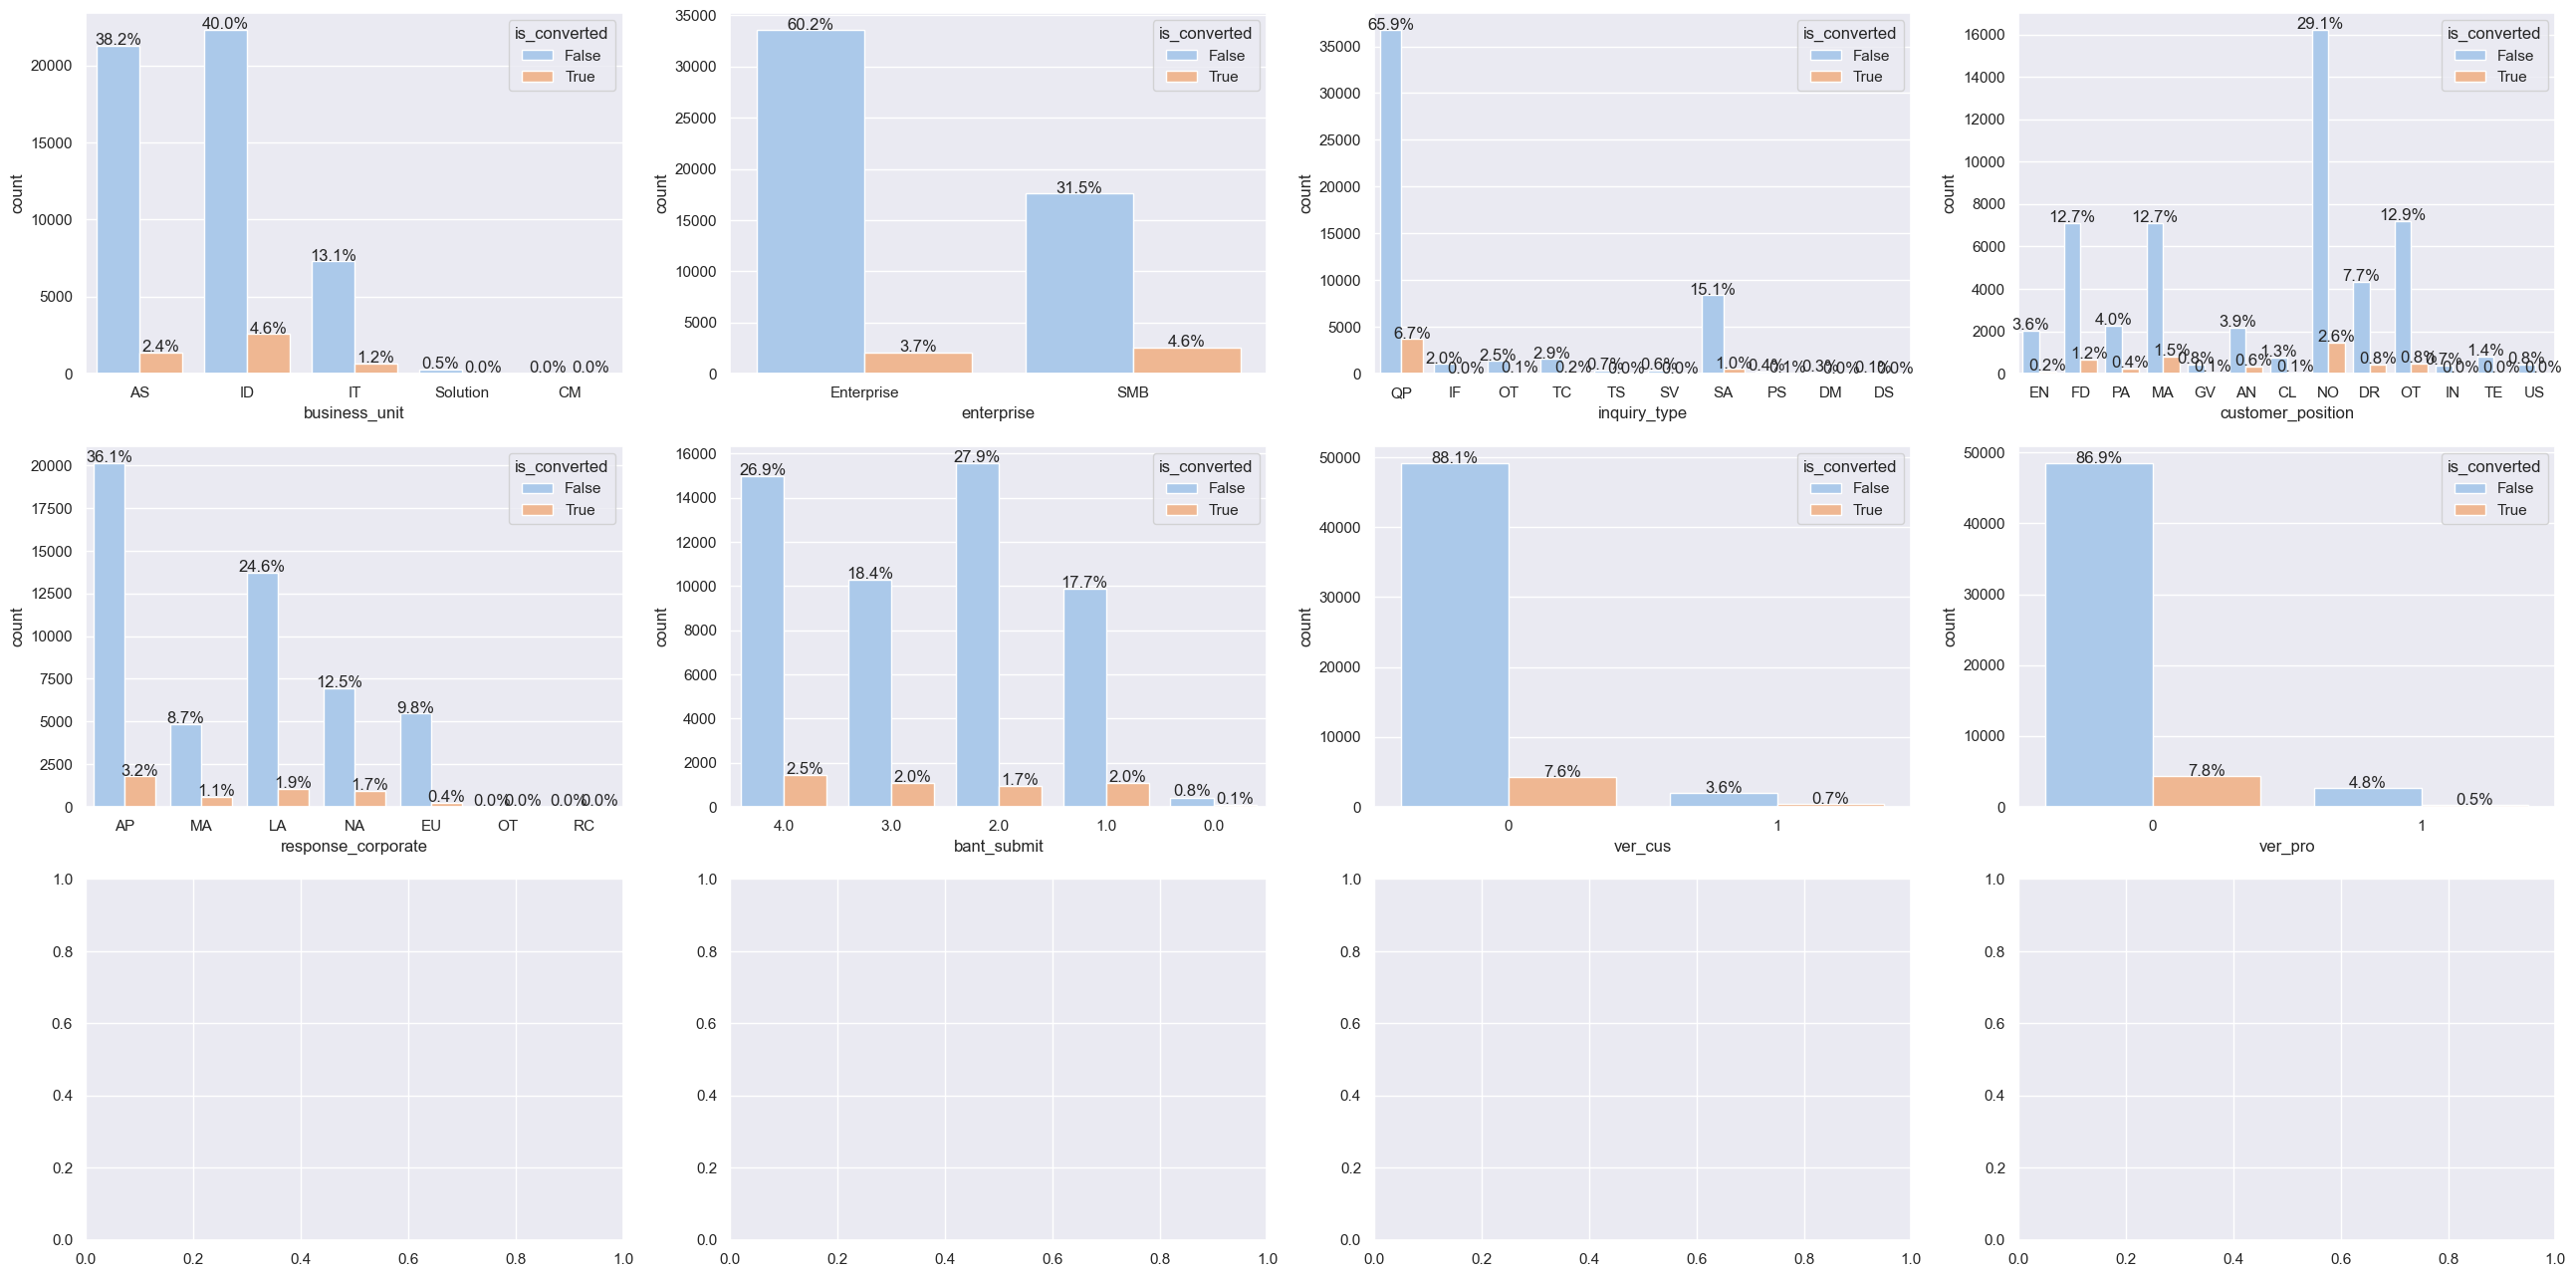

In [239]:
def hist_category_multi(figsize,plot_num,coordinate,data):
    sns.set(rc={"figure.figsize": figsize})
    plot_col=plot_num
    plot_row=int(len(coordinate)/plot_col)+1
    fig,axes=plt.subplots(plot_row,plot_col)

    for n,col in enumerate(coordinate):
        i,j=divmod(n,plot_col)
        sns.countplot(x=col,data=data,hue='is_converted',palette='pastel',ax=axes[i,j])
        write_percent(axes[i,j],len(data))

checklist=copy.deepcopy(colsByType['categorical'])

checklist.remove('customer_country')
checklist.remove('customer_country.1')

hist_category_multi((32,16),4,checklist,data_visual)
#

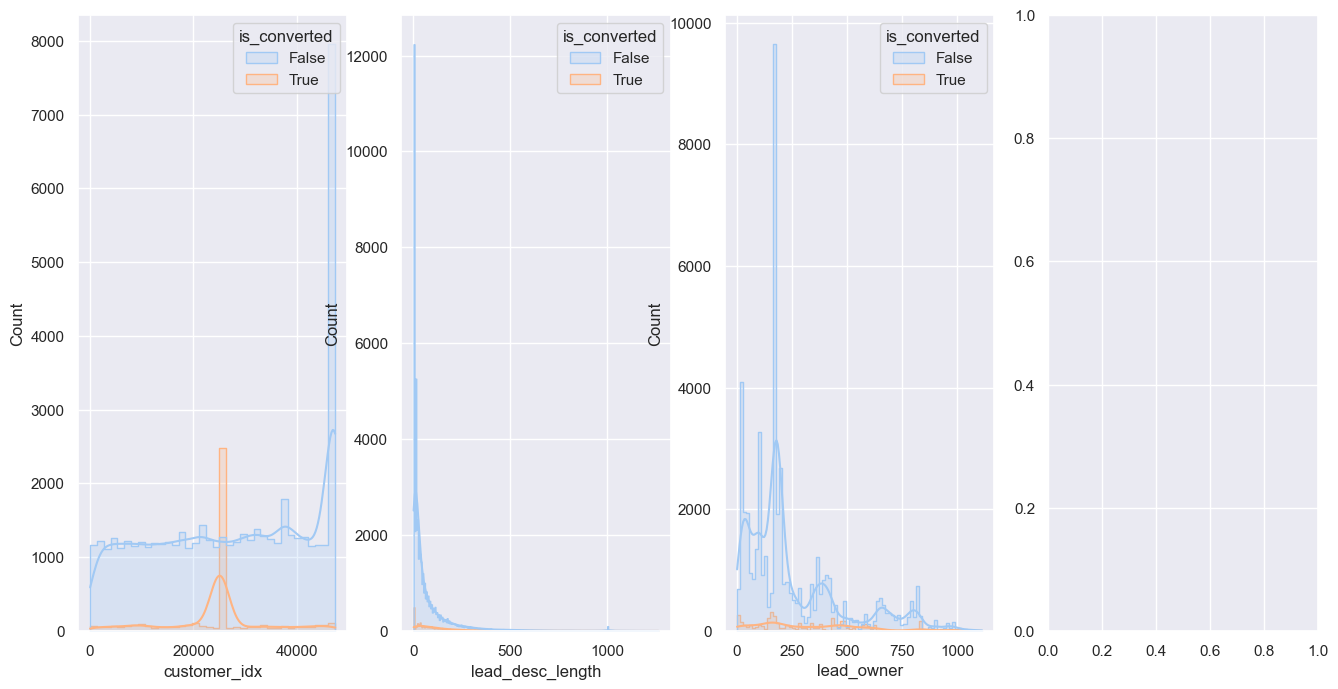

In [251]:
# 숫자형 분포
def hist_numerical_multi(figsize,plot_num,coordinate,data):
    sns.set(rc={"figure.figsize": figsize})
    plot_col=plot_num
    plot_row=int(len(coordinate)/plot_col)+1
    fig,axes=plt.subplots(plot_row,plot_col)

    for n,col in enumerate(coordinate):
        i,j=divmod(n,plot_col)
        sns.histplot(x=col,data=data,kde=True,ax=axes[n],element='step',hue='is_converted',hue_order=[False,True],palette='pastel')

hist_numerical_multi((16,8),4,colsByType['numerical'],data_visual)

## 3. 데이터 처리

In [427]:
# 시드 고정
import os

SEED=42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

In [428]:
train = pd.read_csv("train.csv") # 학습용 데이터
test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [429]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  product_category      

In [430]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5271 non-null   int64  
 1   bant_submit              5271 non-null   float64
 2   customer_country         5271 non-null   object 
 3   business_unit            5271 non-null   object 
 4   com_reg_ver_win_rate     1788 non-null   float64
 5   customer_idx             5271 non-null   int64  
 6   customer_type            3814 non-null   object 
 7   enterprise               5271 non-null   object 
 8   historical_existing_cnt  1275 non-null   float64
 9   id_strategic_ver         593 non-null    float64
 10  it_strategic_ver         53 non-null     float64
 11  idit_strategic_ver       646 non-null    float64
 12  customer_job             3832 non-null   object 
 13  lead_desc_length         5271 non-null   int64  
 14  inquiry_type            

In [431]:
# 학습 타겟 데이터
targets=train['is_converted']

# 한번에 전처리를 위해 데이터 병합
test=test.drop('id',axis=1)
total_data=pd.concat([train,test])
total_data=total_data.drop('is_converted',axis=1)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64570 entries, 0 to 5270
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              64570 non-null  float64
 1   customer_country         63588 non-null  object 
 2   business_unit            64570 non-null  object 
 3   com_reg_ver_win_rate     16356 non-null  float64
 4   customer_idx             64570 non-null  int64  
 5   customer_type            19152 non-null  object 
 6   enterprise               64570 non-null  object 
 7   historical_existing_cnt  15031 non-null  float64
 8   id_strategic_ver         4037 non-null   float64
 9   it_strategic_ver         1174 non-null   float64
 10  idit_strategic_ver       5211 non-null   float64
 11  customer_job             44398 non-null  object 
 12  lead_desc_length         64570 non-null  int64  
 13  inquiry_type             62337 non-null  object 
 14  product_category       

### Train 데이터 기준으로 전처리

In [432]:
# columns
colsByType={}

colsByType['categorical']=train.columns[train.dtypes=='object'].tolist()
colsByType['numerical']=train.columns[train.dtypes!='object'].tolist()
#colsByType['numerical'].remove('is_converted')

print('\nnumerical columns: '+str(len(colsByType['numerical'])))
print('categorical columns: '+str(len(colsByType['categorical'])))
print('total columns: '+str(len(colsByType['numerical'])+len(colsByType['categorical'])))


numerical columns: 14
categorical columns: 15
total columns: 29


In [433]:
# 결측치 테이블
nanCols=train.columns.to_list()
temp=[]
for col in nanCols:
    if col in colsByType['numerical']:
        temp.append([col,'num',train[col].isnull().sum(),''])
    else:
        temp.append([col,'cat',train[col].isnull().sum(),''])

nanData=pd.DataFrame(data=temp,columns=['Column','Type','Count','Deal'])
nanData

,Column,Type,Count,Deal
0,bant_submit,num,0,
1,customer_country,cat,982,
2,business_unit,cat,0,
3,com_reg_ver_win_rate,num,44731,
4,customer_idx,num,0,
5,customer_type,cat,43961,
6,enterprise,cat,0,
7,historical_existing_cnt,num,45543,
8,id_strategic_ver,num,55855,
9,it_strategic_ver,num,58178,


In [434]:
# 삭제 후보군 결측치 10% 이상
baseLine=int(rows*0.1)

delCol=train.isnull().sum()[train.isnull().sum()>baseLine].index.tolist()
delCol

['com_reg_ver_win_rate',
 'customer_type',
 'historical_existing_cnt',
 'id_strategic_ver',
 'it_strategic_ver',
 'idit_strategic_ver',
 'customer_job',
 'product_category',
 'product_subcategory',
 'product_modelname',
 'expected_timeline',
 'ver_win_rate_x',
 'ver_win_ratio_per_bu',
 'business_area',
 'business_subarea']

In [435]:
total_data=total_data.drop(delCol,axis=1)

for dc in delCol:
    nanData.loc[nanData['Column']==dc,'Deal']='Remove'
nanData

,Column,Type,Count,Deal
0,bant_submit,num,0,
1,customer_country,cat,982,
2,business_unit,cat,0,
3,com_reg_ver_win_rate,num,44731,Remove
4,customer_idx,num,0,
5,customer_type,cat,43961,Remove
6,enterprise,cat,0,
7,historical_existing_cnt,num,45543,Remove
8,id_strategic_ver,num,55855,Remove
9,it_strategic_ver,num,58178,Remove


In [436]:
# country 데이터 추후 수정 (우선 제거)
delCol=['customer_country','customer_country.1']
total_data=total_data.drop(delCol,axis=1)

for dc in delCol:
    nanData.loc[nanData['Column']==dc,'Deal']='Remove'
nanData

,Column,Type,Count,Deal
0,bant_submit,num,0,
1,customer_country,cat,982,Remove
2,business_unit,cat,0,
3,com_reg_ver_win_rate,num,44731,Remove
4,customer_idx,num,0,
5,customer_type,cat,43961,Remove
6,enterprise,cat,0,
7,historical_existing_cnt,num,45543,Remove
8,id_strategic_ver,num,55855,Remove
9,it_strategic_ver,num,58178,Remove


In [437]:
# 전체 처리
# columns
colsByType={}

colsByType['categorical']=total_data.columns[total_data.dtypes=='object'].tolist()
colsByType['numerical']=total_data.columns[total_data.dtypes!='object'].tolist()
#colsByType['numerical'].remove('is_converted')

print('\nnumerical columns: '+str(len(colsByType['numerical'])))
print('categorical columns: '+str(len(colsByType['categorical'])))
print('total columns: '+str(len(colsByType['numerical'])+len(colsByType['categorical'])))


numerical columns: 6
categorical columns: 5
total columns: 11


In [438]:
# 범주형 전처리
# 묶음
# [quotation, purchase ] -> QP
# technical -> TC
# information -> IF
# partnership -> PS
# demo -> DM
# trainings ->TS
# services -> SV
# sales -> SA
# distributorship ->DS
# others -> OT

def preprocess_inquiry_type(x):
    permitted={'quotation':'QP','purchase':'QP','technical':'TC','information':'IF','partnership':'PS','demo':'DM','trainings':'TS','services':'SV','sales':'SA','distributorship':'DS'}

    if type(x)==type(''):
        x=x.lower().replace('_',' ')
        for word in x.split(' '):
            if permitted.get(word):
                return permitted[word]
        return 'OT'
    return np.nan

total_data['inquiry_type']=total_data['inquiry_type'].apply(lambda x:preprocess_inquiry_type(x))
total_data['inquiry_type'].value_counts()

QP    45849
SA    10081
TC     1965
OT     1604
IF     1305
TS      455
SV      449
PS      360
DM      193
DS       76
Name: inquiry_type, dtype: int64

In [439]:
# none -> NO
# manager -> MA
# founder -> FD
# director -> DR
# entry -> EN
# analyst -> AN
# partner -> PA
# c -> CL
# trainee -> TE
# intern  -> IN
# president, government -> GV
# user -> US
# other -> OT

def preprocess_customer_position(x):
    permitted={'none':'NO','manager':'MA','founder':'FD','director':'DR','entry':'EN','analyst':'AN','partner':'PA','c':'CL','trainee':'TE','intern':'IN','president':'GV','goverment':'GV','user':'US'}

    if type(x)==type(''):
        x=x.lower().replace('-',' ').replace('/',' ')
        for word in x.split(' '):
            if permitted.get(word):
                return permitted[word]
        return 'OT'
    return np.nan

total_data['customer_position']=total_data['customer_position'].apply(lambda x:preprocess_customer_position(x))
total_data['customer_position'].value_counts()

NO    21637
MA     8943
OT     8798
FD     8581
DR     5191
AN     2876
PA     2762
EN     2441
CL      942
TE      898
GV      564
IN      506
US      431
Name: customer_position, dtype: int64

In [440]:
# 자사법인명 2020 기준으로 cf overseas 참조
# EUROPE -> LGEAG, LGECZ, LGEFS, LGEDG, LGEHS, LGEMK, LGEIS, LGESC, LGEEH, LGEBN, LGEWR, LGEPL, LGEMA, LGEPT, LGERO, LGEES, LGENO, LGESW, LGEUK -> EU
# RUSSIA$CIS -> LGEAK, LGERM, LGERI, LGERA, LGEUR, LGELV -> RC
# MIDDLE EAST & AFRICA -> 	LGEAS, LGEEG, LGELF, LGESK, LGEMC, LGESA, LGETU, LGEOT, LGEDF, LGEGF, LGEME, LGEAF, LEAO, LGENI, LGETK, LGEAT -> MA
# ASIA & PACIFIC -> LGEAP, LGEQA, LGETL, LGECH, LGEYT, LGETR, LGETA, LGESY, LGESH, LGEQH, LGEQD, LGEPN, LGENE, LGEKS, LGEHZ, LGEHN, LGEHK -> AP
# NORTH AMERICA -> LGECI, LGERS, LGEMX, LGEMS, LGEMM, LGEMR, LGEUS, LGEMU, LGEAI -> NA
# LATIN AMERICA ->LGEAG, LGEBR, LGECL, LGEVZ, LGECB, LGEPS, LGEPR -> LA

# add
# LGEIL -> 인도 뉴델리 -> AP
# LGESP -> 브라질 상파울로 -> LA
# LGEPH -> 필리핀 -> AP
# LGESJ -> 사우디아라비아 제다 -> MA
# LGEVH -> 베트남 하이퐁 -> AP
# LGEAR -> 아르헨티나 부에노스아이레스 -> LA
# LGEKR -> 한국 -> AP
# LGESL -> 싱가포르 싱가포르 -> AP
# LGEIN -> 인도네시아 자카르타 -> AP
# LGETH -> 태국 라용 -> AP
# LGEEF -> 케냐 -> MA
# LGEML -> 말레이시아 쿠알라룸푸르 -> AP
# LGEYK -> 이스라엘 -> MA
# LGETT -> 대만 타이페이 -> AP
# LGEJP -> 일본 동경 -> AP
# LGEEB -> 모름 -> OT
# LGELA -> 모름 -> OT
# LGEIR -> 이란 -> MA
# LGEBT -> 모름 -> OT

def preprocess_response_corporate(x):
    permitted_inverse={'EU':['LGEAG', 'LGECZ', 'LGEFS', 'LGEDG', 'LGEHS', 'LGEMK', 'LGEIS', 'LGESC', 'LGEEH', 'LGEBN', 'LGEWR', 'LGEPL', 'LGEMA', 'LGEPT', 'LGERO', 'LGEES', 'LGENO', 'LGESW', 'LGEUK'],
                       'RC':['LGEAK', 'LGERM', 'LGERI', 'LGERA', 'LGEUR', 'LGELV'],
                       'MA':['LGEAS', 'LGEEG', 'LGELF', 'LGESK', 'LGEMC', 'LGESA', 'LGETU', 'LGEOT', 'LGEDF', 'LGEGF', 'LGEME', 'LGEAF', 'LGEAO', 'LGENI', 'LGETK', 'LGEAT', 'LGESJ', 'LGEEF', 'LGEYK', 'LGEIR'],
                       'AP':['LGEAP', 'LGEQA', 'LGETL', 'LGECH', 'LGEYT', 'LGETR', 'LGETA', 'LGESY', 'LGESH', 'LGEQH', 'LGEQD', 'LGEPN', 'LGENE', 'LGEKS', 'LGEHZ', 'LGEHN', 'LGEHK', 'LGEIL', 'LGEPH', 'LGEVH', 'LGEKR', 'LGESL', 'LGEIN', 'LGETH', 'LGEML', 'LGETT', 'LGEJP'],
                       'NA':['LGECI', 'LGERS', 'LGEMX', 'LGEMS', 'LGEMM', 'LGEMR', 'LGEUS', 'LGEMU', 'LGEAI'],
                       'LA':['LGEAG', 'LGEBR', 'LGECL', 'LGEVZ', 'LGECB', 'LGEPS', 'LGEPR', 'LGESP', 'LGEAR'],
                       'OT':['LGEEB', 'LGELA', 'LGEBT']}
    permitted={}
    for pi in permitted_inverse.keys():
        for code in permitted_inverse[pi]:
            permitted[code]=pi
    
    if type(x)==type(''):
        if permitted.get(x):
            return permitted[x]
        return x
    return np.nan

total_data['response_corporate']=total_data['response_corporate'].apply(lambda x:preprocess_response_corporate(x))
total_data['response_corporate'].value_counts()

AP    23999
LA    17264
NA    10193
EU     6646
MA     6443
OT       16
RC        9
Name: response_corporate, dtype: int64

In [441]:
# 4개의 조건의 우선순위를 모름 -> 어떻게 평가 됬는지도 모름 -> 전체 작성 수준을 등급으로
def preprocess_bant_submit(x):
    return str(x*4)

total_data['bant_submit']=total_data['bant_submit'].apply(lambda x:preprocess_bant_submit(x))
colsByType['numerical'].remove('bant_submit')
colsByType['categorical'].append('bant_submit')
total_data['bant_submit'].value_counts()

4.0    19131
2.0    17859
1.0    14374
3.0    12226
0.0      980
Name: bant_submit, dtype: int64

In [442]:
# 0, 1인 컬럼 범주형 데이터로 해석
colsByType['numerical'].remove('ver_cus')
colsByType['numerical'].remove('ver_pro')
colsByType['categorical'].append('ver_cus')
colsByType['categorical'].append('ver_pro')
colsByType['categorical']

['business_unit',
 'enterprise',
 'inquiry_type',
 'customer_position',
 'response_corporate',
 'bant_submit',
 'ver_cus',
 'ver_pro']

In [443]:
# enterprise 0,1로 변환
total_data['enterprise']=total_data['enterprise'].replace('Enterprise',1)
total_data['enterprise']=total_data['enterprise'].replace('SMB',0)
total_data['enterprise'].info()

<class 'pandas.core.series.Series'>
Int64Index: 64570 entries, 0 to 5270
Series name: enterprise
Non-Null Count  Dtype
--------------  -----
64570 non-null  int64
dtypes: int64(1)
memory usage: 1008.9 KB


In [444]:
contents=[]
for col in colsByType['numerical']:
    contents.append([col,total_data[col].skew()])

table=pd.DataFrame(data=contents,columns=['Column','SKEW'])
table

,Column,SKEW
0,customer_idx,-0.122879
1,lead_desc_length,3.593431
2,lead_owner,1.248199


In [445]:
# log 스케일
for col in colsByType['numerical']:
    total_data[col]=np.log1p(total_data[col])

### 결측치 처리 하나씩

In [446]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64570 entries, 0 to 5270
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bant_submit         64570 non-null  object 
 1   business_unit       64570 non-null  object 
 2   customer_idx        64570 non-null  float64
 3   enterprise          64570 non-null  int64  
 4   lead_desc_length    64570 non-null  float64
 5   inquiry_type        62337 non-null  object 
 6   customer_position   64570 non-null  object 
 7   response_corporate  64570 non-null  object 
 8   ver_cus             64570 non-null  int64  
 9   ver_pro             64570 non-null  int64  
 10  lead_owner          64570 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 5.9+ MB


In [447]:
# 범주형은 최빈값으로 대체
mode_cols=[]
def replace_mode(cols,table,data):
    for col in cols:
        data[col]=data[col].fillna(data[col].mode()[0])
        table.loc[table['Column']==col,'Deal']='Mode'

replace_mode(colsByType['categorical'],nanData,total_data)
nanData

,Column,Type,Count,Deal
0,bant_submit,num,0,Mode
1,customer_country,cat,982,Remove
2,business_unit,cat,0,Mode
3,com_reg_ver_win_rate,num,44731,Remove
4,customer_idx,num,0,
5,customer_type,cat,43961,Remove
6,enterprise,cat,0,Mode
7,historical_existing_cnt,num,45543,Remove
8,id_strategic_ver,num,55855,Remove
9,it_strategic_ver,num,58178,Remove


In [448]:
# 숫자형 결측치 대체 KNN,MICE 사용
#from fancyimpute import KNN
from fancyimpute import IterativeImputer

imputer=IterativeImputer()
objectData=total_data.drop(colsByType['numerical'],axis=1)
mice=total_data.drop(colsByType['categorical'],axis=1)
mice.iloc[:,:]=imputer.fit_transform(mice)
data=pd.concat([objectData,mice],axis=1)
nanData.loc[(nanData['Type']=='num')&(nanData['Deal']==''),'Deal']='MICE'
nanData


,Column,Type,Count,Deal
0,bant_submit,num,0,Mode
1,customer_country,cat,982,Remove
2,business_unit,cat,0,Mode
3,com_reg_ver_win_rate,num,44731,Remove
4,customer_idx,num,0,MICE
5,customer_type,cat,43961,Remove
6,enterprise,cat,0,Mode
7,historical_existing_cnt,num,45543,Remove
8,id_strategic_ver,num,55855,Remove
9,it_strategic_ver,num,58178,Remove


In [449]:
total_data.columns

Index(['bant_submit', 'business_unit', 'customer_idx', 'enterprise',
       'lead_desc_length', 'inquiry_type', 'customer_position',
       'response_corporate', 'ver_cus', 'ver_pro', 'lead_owner'],
      dtype='object')

In [456]:
dummyData=pd.get_dummies(total_data)
dummyData.shape

(64570, 46)

In [457]:
targets=targets.apply(lambda x:1 if x else 0)
targets.info()

<class 'pandas.core.series.Series'>
RangeIndex: 59299 entries, 0 to 59298
Series name: is_converted
Non-Null Count  Dtype
--------------  -----
59299 non-null  int64
dtypes: int64(1)
memory usage: 463.4 KB


In [458]:
trainDummy=dummyData[:59299]
testDummy=dummyData[59299:]
print(trainDummy.shape)
print(testDummy.shape)
print(targets.shape)
print(trainDummy.isnull().sum()[trainDummy.isnull().sum()>0])
print(testDummy.isnull().sum()[testDummy.isnull().sum()>0])

(59299, 46)
(5271, 46)
(59299,)
Series([], dtype: int64)
Series([], dtype: int64)


In [459]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from mlxtend.classifier import StackingClassifier


In [464]:
models=[
    LogisticRegression(random_state=SEED),
    SVC(random_state=SEED),
    DecisionTreeClassifier(random_state=SEED),
    GradientBoostingClassifier(n_estimators=1000,learning_rate=0.05,random_state=SEED),
    RandomForestClassifier(n_estimators=1000,random_state=SEED),
    LGBMClassifier(n_estimators=1000,learning_rate=0.05,random_state=SEED),
    XGBClassifier(learning_rate=0.05,random_state=SEED,objective='binary:logistic',eval_metric='logloss'),
    CatBoostClassifier(random_seed=SEED),
    StackingClassifier(classifiers=(LogisticRegression(random_state=SEED),
                                    RandomForestClassifier(random_state=SEED),
                                    CatBoostClassifier(random_seed=SEED)),
                                    meta_classifier=CatBoostClassifier(random_seed=SEED))
]
model_names=[
    'LogisticRegression',
    'SVC',
    'DecisionTreeClassifier',
    'GradientBoostingClassifier',
    'RandomForestClassifier',
    'LGBMClassifier',
    'XGBClassifier',
    'CatBoostClassifier',
    'StackingClassifier'
]

In [465]:
# 학습 데이터 분리 -> target 값이 편향되어 있으므로 각 라벨별로 균등하게 들어가게 조정해서 넣어봄
train_X,val_X,train_y,val_y=train_test_split(trainDummy,targets,test_size=0.2,shuffle=True,stratify=targets,random_state=SEED)

In [466]:
# 모델 성능 테스트
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))
    return F1

In [467]:
# test code
best_model=None
best_score=-1
best_model_name=None
for i,model in enumerate(models):
    print(model_names[i]+' start\n')
    model.fit(train_X,train_y)
    pred=model.predict(val_X)
    score=get_clf_eval(val_y,pred)
    if score>best_score:
        best_score=score
        best_model=model
        best_model_name=model_names[i]



LogisticRegression start

오차행렬:
 [[    8   962]
 [    9 10881]]

정확도: 0.9181
정밀도: 0.4706
재현율: 0.0082
F1: 0.0162
SVC start

오차행렬:
 [[    0   970]
 [    0 10890]]

정확도: 0.9182
정밀도: 0.0000
재현율: 0.0000
F1: 0.0000
DecisionTreeClassifier start

오차행렬:
 [[  752   218]
 [  236 10654]]

정확도: 0.9617
정밀도: 0.7611
재현율: 0.7753
F1: 0.7681
GradientBoostingClassifier start

오차행렬:
 [[  638   332]
 [   40 10850]]

정확도: 0.9686
정밀도: 0.9410
재현율: 0.6577
F1: 0.7743
RandomForestClassifier start

오차행렬:
 [[  686   284]
 [   32 10858]]

정확도: 0.9734
정밀도: 0.9554
재현율: 0.7072
F1: 0.8128
LGBMClassifier start

[LightGBM] [Info] Number of positive: 3880, number of negative: 43559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info] Number of data points in the train set: 47439, number of used features

In [468]:
best_model_name

'RandomForestClassifier'

In [469]:
test_X=testDummy
test_pred=best_model.predict(test_X)
submission=pd.read_csv('submission.csv')
submission['is_converted']=test_pred

submission.to_csv('submission.csv',index=False)
submission.head()

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,0
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,1
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,0
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,0
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,0
